In [1]:
from __future__ import division
import os.path
import numpy as np
import tqdm # task bar
import matplotlib.pyplot as plt
%matplotlib notebook
import idx2numpy as inp
import scipy.sparse.linalg
import scipy.spatial.distance as dist

# Loads Database

In [2]:
# also vectorises each 28 x 28 pixel image to a 784-element vector
TrImgs = np.array([img.flatten() for img in inp.convert_from_file('train-images.idx3-ubyte')])
TrLbls = inp.convert_from_file('train-labels.idx1-ubyte')
TsImgs = np.array([img.flatten() for img in inp.convert_from_file('t10k-images.idx3-ubyte')])
TsLbls = inp.convert_from_file('t10k-labels.idx1-ubyte')
# calculate TRAINING IMGS mean for use in rest of program
TrImgsMean = (np.mean(TrImgs,axis=0)).astype('float')

In [3]:
def pca(Imgs):
    """
    Principle Component Analysis: 
    1. mean-shifts all images
    2. generates list of vectors (principle components (pc)), 
    organised according to descending eigenvalues.
    
    :Params Imgs: List of images
    
    Returns:
    u: unitary matrix of pc's
    d: singular values in descending order
    """
    ImgsMean = TrImgsMean
    ImgsShifted = (Imgs-ImgsMean)
    Cov = np.cov(ImgsShifted.T)
#     EVals, EVecs = np.linalg.eig(Cov)
    EVecs, EVals, V = np.linalg.svd(Cov)
    EValsSorted = np.flipud(np.sort(np.real(EVals))) # sorts eigenvalues in descending order
    EVecsSorted = np.real(EVecs[np.flipud(np.argsort(np.real(EVals)))]) # sorts eigenvectors in the same order as EValsSorted
    return EValsSorted, EVecsSorted

In [4]:
TrD, TrU = pca(TrImgs)

In [9]:
np.save('training_set_variances',TrD)
np.save('training_set_principle_components',TrU)

In [4]:
TrD = np.load('training_set_variances.npy')
TrU = np.load('training_set_principle_components.npy')

In [5]:
def ReconstImgs(Imgs, u, p):
    """
    Reconstruct Images in Reduced Dimensions:
    1. mean-shifts all images according to TRAINING-SET MEAN 
    (not test-set mean, since all the basis vectors are defined wrt to 
    the training-set.)
    2. picks up p columns of u as a reduced basis set.
    3. reconstructs the image using this reduced basis set, 
    returns the mean shifted value.
    
    :params Imgs: Imgs.T 
    :params u: u.T gives column-organised basis set
    :params p: reduced dimension to output
    """
    ImgsMean = TrImgsMean
    ImgsShifted = (Imgs-ImgsMean)
    uCols = u.T[:p] # transpose to get columns, use the first p columns
    return (ImgsMean + (np.dot(np.dot(uCols.T,uCols),ImgsShifted.T)).T).astype('int')

## FIND THRESHOLD NUMBER OF FEATURES

include 153 features to reach 95% threshold


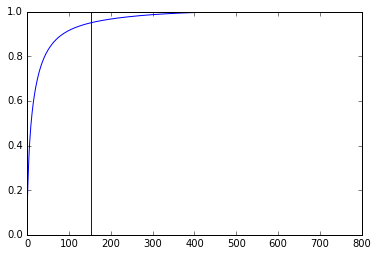

In [6]:
feature_fraction = np.cumsum(TrD)/np.sum(TrD)
threshold = np.argmin(np.abs(feature_fraction-0.95))
print 'include {} features to reach 95% threshold'.format(threshold)
plt.figure()
plt.plot(feature_fraction)
plt.axvline(threshold)
plt.show()

## VISUALISE RECONSTRUCTED IMAGE

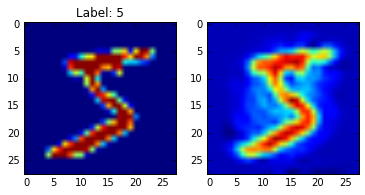

In [15]:
i = 0 #image index
p = 153 #set number of principle components
f, (ax0, ax1) = plt.subplots(1,2)
ax0.imshow(TrImgs[i].reshape(28,28)) #original
ax0.set_title('Label: '+str(TrLbls[i])) #original label
r = ReconstImgs(TrImgs[i:i+1],TrU,p) #process 10 images only for speed
# print r
ax1.imshow((TrImgsMean+r[0].astype('int')).reshape(28,28))
plt.show()

# Projected Data

## 2 Components

In [6]:
def Comps(Imgs, u, p):
    """
    Components in Reduced Dimensions:
    1. mean-shifts all images according to TRAINING-SET MEAN 
    (not test-set mean, since all the basis vectors are defined wrt to 
    the training-set.)
    2. picks up p columns of u as a reduced basis set.
    3. returns the component sizes
    
    :params Imgs: Imgs.T 
    :params u: u.T gives column-organised basis set
    :params p: reduced dimension to output
    """
    ImgsMean = TrImgsMean
    ImgsShifted = (Imgs-ImgsMean)
    uCols = u.T[:p] # transpose to get columns, use the first p columns
    print uCols.shape
    return np.dot(uCols,ImgsShifted.T)

In [39]:
Imgs2Comps = Comps(TrImgs,TrU,2)

(2, 784)


In [40]:
Imgs2Comps[0].shape

(60000,)

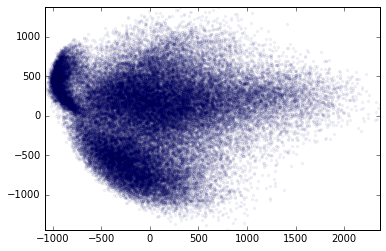

In [41]:
plt.figure()
# plt.autoscale(enable=False)
plt.scatter(Imgs2Comps[0],Imgs2Comps[1],marker='.',alpha=0.05)
plt.xlim(np.min(Imgs2Comps[0]),np.max(Imgs2Comps[0]))
plt.ylim(np.min(Imgs2Comps[1]),np.max(Imgs2Comps[1]))
plt.show()

## 3 Components

In [42]:
Imgs3Comps = Comps(TrImgs,TrU,3)

(3, 784)


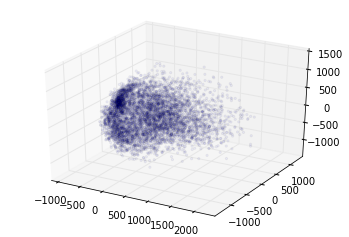

In [43]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Imgs3Comps[0][::10],Imgs3Comps[1][::10],Imgs3Comps[2][::10],marker='.',alpha=0.05)
ax.set_xlim(np.min(Imgs3Comps[0]),np.max(Imgs3Comps[0]))
ax.set_ylim(np.min(Imgs3Comps[1]),np.max(Imgs3Comps[1]))
ax.set_zlim(np.min(Imgs3Comps[2]),np.max(Imgs3Comps[2]))
plt.show()

## Visualise first 10 eigenvectors

<IPython.core.display.Javascript object>


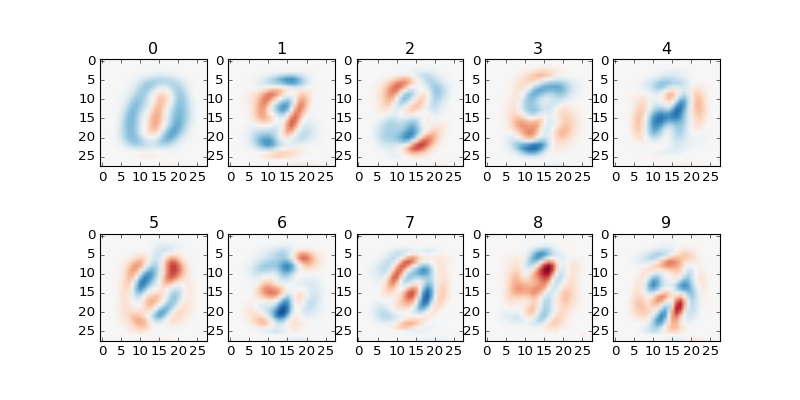

12.4076992129
0.878135147853
1.72242790782
2.56031583265
7.4924652591
-3.45312816162
5.06582945968
0.550278799164
-6.58489629181
-0.660302753447


In [8]:
f, axes = plt.subplots(2,5, figsize=(10,5))
for i in range(10):
    print np.sum(TrU.T[i])
    axes[int(i/5),i%5].imshow((TrU.T[i]).reshape(28,28),
                             vmin=-0.2,vmax=0.2,cmap='RdBu')
    axes[int(i/5),i%5].set_title(i)
    plt.savefig('PCA_SVD_eigenvectors.pdf')
    plt.show()

# Generate Data of reduced dimensions and save

In [3]:
if all([os.path.exists('TrImgs{}Comps.npy'.format(c)) for c in [40,80,200]]):
    # load if exists
    [TrImgs40Comps,TrImgs80Comps,TrImgs200Comps] = [np.load('TrImgs{}Comps.npy'.format(c)) for c in [40,80,200]]
else:
    # generate for data of reduced dimensions (Training Set)
    TrImgs40Comps = ReconstImgs(TrImgs,TrU,40)
    TrImgs80Comps = ReconstImgs(TrImgs,TrU,80)
    TrImgs200Comps = ReconstImgs(TrImgs,TrU,200)
    [np.save('TrImgs{}Comps'.format(c),carr) for c, carr in zip([40,80,200],[TrImgs40Comps,TrImgs80Comps,TrImgs200Comps])]

True


In [ ]:
if all([os.path.exists('TsImgs{}Comps.npy'.format(c)) for c in [40,80,200]]):
    # load if exists
    [TsImgs40Comps,TsImgs80Comps,TsImgs200Comps] = [np.load('TsImgs{}Comps.npy'.format(c)) for c in [40,80,200]]
else:
    # generate for data of reduced dimensions (Test Set)
    TsImgs40Comps = ReconstImgs(TsImgs,TrU,40)
    TsImgs80Comps = ReconstImgs(TsImgs,TrU,80)
    TsImgs200Comps = ReconstImgs(TsImgs,TrU,200)
    [np.save('TsImgs{}Comps'.format(c),carr) for c, carr in zip([40,80,200],[TsImgs40Comps,TsImgs80Comps,TsImgs200Comps])]

## Visualise reconstructed TEST data

<IPython.core.display.Javascript object>


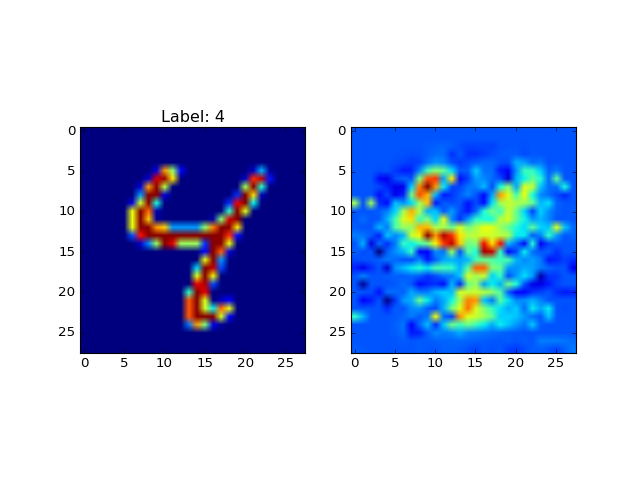

In [24]:
i = 6 #image index
p = 100 #set number of principle components
f, (ax0, ax1) = plt.subplots(1,2)
ax0.imshow(TsImgs[i].reshape(28,28)) #original
ax0.set_title('Label: '+str(TsLbls[i])) #original label
r = ReconstImgs(TsImgs[i:i+1],TrU,p) #process 10 images only for speed
ax1.imshow((r).reshape(28,28))

In [3]:
def KCl(x,TrImgsPComps):
    """
    K-Nearest neighbours classifier
    1. Compute relative distances between x(one picture) and TrImgsPComps(many pictures)
    2. Find nearest neighbor's class: use this to classify x.
    
    Note: Ensure x and elements in TrImgsPComps have the same number of components.
    """
    try:
        EucDist = dist.cdist(x,TrImgsPComps)
        NeighborIdx = np.argmin(EucDist)
        NeighborLbl = TrLbls[NeighborIdx]
        return (NeighborLbl)
    except:
        raise

In [9]:
# Test KCl
i=0
KCl(TsImgs[i:i+1],TrImgs)==TsLbls[i]

True

In [11]:
def KCl_Batched(TsImgsPComps,TrImgsPComps):
    return np.array([KCl(TsImgsPComps[i:i+1],TrImgsPComps) 
                     for i in tqdm.tqdm(np.arange(len(TsImgsPComps)))
                    ])

# Classify Traces with 40, 80, 200 Components

In [50]:
TsImgs40Comps_Class = KCl_Batched(TsImgs40Comps,TrImgs40Comps)

100%|██████████| 10000/10000 [1:03:04<00:00,  3.21it/s]


In [51]:
np.savetxt('TsImgs40Comps_Class.dat',TsImgs40Comps_Class)

In [13]:
print 'Classification Error for 40 components = {:.2f}%'.format(
    np.sum(np.logical_xor(TsImgs40Comps_Class,TsLbls))*100./len(TsLbls))

Classification Error for 40 components = 0.84%


In [15]:
print 'Classification Error for 40 components = {:.2f}%'.format(
    np.sum(TsImgs40Comps_Class!=TsLbls)*100./len(TsLbls))

Classification Error for 40 components = 4.18%


note: 
* timing requirements for vectors with negative integers seem higher than for unsigned integers.

In [12]:
KCl(TsImgs80Comps[0:1],np.array(TrImgs80Comps))

7

In [14]:
TsImgs80Comps_Class = KCl_Batched(TsImgs80Comps,TrImgs80Comps)

100%|██████████| 10000/10000 [42:59<00:00,  3.88it/s]


In [15]:
np.savetxt('TsImgs80Comps_Class.dat',TsImgs80Comps_Class)

In [16]:
TsImgs80Comps_Class = np.loadtxt('TsImgs80Comps_Class.dat')

In [17]:
print 'Classification Error for 80 components = {:.2f}%'.format(
    np.sum(TsImgs80Comps_Class!=TsLbls)*100./len(TsLbls))

Classification Error for 80 components = 3.86%


In [17]:
TsImgs200Comps_Class = KCl_Batched(TsImgs200Comps,TrImgs200Comps)

100%|██████████| 10000/10000 [43:27<00:00,  3.84it/s]


In [ ]:
np.savetxt('TsImgs200Comps_Class.dat',TsImgs200Comps_Class)

In [3]:
TsImgs200Comps_Class = np.loadtxt('TsImgs200Comps_Class.dat')

In [4]:
print 'Classification Error for 200 components = {:.2f}%'.format(
    np.sum(TsImgs200Comps_Class!=TsLbls)*100./len(TsLbls))

Classification Error for 200 components = 3.50%


# Classify traces with 153 components

In [7]:
print (1/len(TsImgs))*100

0.01
